In [43]:
# Rossmann Store Sales https://www.kaggle.com/c/rossmann-store-sales

In [44]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

In [45]:
train = pd.read_csv('../data/train.csv', parse_dates=['Date'])
test = pd.read_csv('../data/test.csv', parse_dates=['Date'])
store = pd.read_csv('../data/store.csv')

### Train and test
- Id - an Id that represents a (Store, Date) duple within the test set.<br>
- Store - a unique Id for each store.<br>
- DayOfWeek - from 1 to 7
- Date
- Sales: the turnover for any given day (target variable).<br>
- Customers: the number of customers on a given day.<br>
- Open: an indicator for whether the store was open: 0 = closed, 1 = open.<br>
- Promo: indicates whether a store is running a promo on that day: 0 = no, 1 = yes.<br>
- StateHoliday: indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. a = public holiday, b = Easter holiday, c = Christmas, 0 = None<br>
- SchoolHoliday: indicates if the (Store, Date) was affected by the closure of public schools. All schools are closed on public holidays and weekends: 0 = no, 1 = yes.

In [46]:
train.head().append(train.tail())

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1
1017204,1111,2,2013-01-01,0,0,0,0,a,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1
1017208,1115,2,2013-01-01,0,0,0,0,a,1


In [47]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   Store          1017209 non-null  int64         
 1   DayOfWeek      1017209 non-null  int64         
 2   Date           1017209 non-null  datetime64[ns]
 3   Sales          1017209 non-null  int64         
 4   Customers      1017209 non-null  int64         
 5   Open           1017209 non-null  int64         
 6   Promo          1017209 non-null  int64         
 7   StateHoliday   1017209 non-null  object        
 8   SchoolHoliday  1017209 non-null  int64         
dtypes: datetime64[ns](1), int64(7), object(1)
memory usage: 69.8+ MB


In [48]:
test.head().append(test.tail())

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0
41083,41084,1111,6,2015-08-01,1.0,0,0,0
41084,41085,1112,6,2015-08-01,1.0,0,0,0
41085,41086,1113,6,2015-08-01,1.0,0,0,0
41086,41087,1114,6,2015-08-01,1.0,0,0,0
41087,41088,1115,6,2015-08-01,1.0,0,0,1


In [49]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Id             41088 non-null  int64         
 1   Store          41088 non-null  int64         
 2   DayOfWeek      41088 non-null  int64         
 3   Date           41088 non-null  datetime64[ns]
 4   Open           41077 non-null  float64       
 5   Promo          41088 non-null  int64         
 6   StateHoliday   41088 non-null  object        
 7   SchoolHoliday  41088 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(5), object(1)
memory usage: 2.5+ MB


In [50]:
for df in [train, test]:
    df['StateHoliday'] = df['StateHoliday'].astype(str)

#### Observation with Open = 0,  Sales = 0 

In [51]:
# len(test[test['Open'] == 0])

In [52]:
# len(train[(train['Open'] == 0) & (train['Sales'] != 0)])

In [53]:
# len(train[train['Open'] == 0])

In [54]:
# len(train[(train['Open'] != 0) & (train['Sales'] == 0)])

According to the task description at kaggle site, observations with Open=0 will be ignored in scoring. So, it's reasonable to exclude observations with Open=0 from train.
There are also few observation in train with Sales=0. Let's also exclude them.

In [55]:
train = train[train['Sales'] != 0]

In [56]:
train.shape

(844338, 9)

#### Missing values imputation

In [57]:
train.isnull().sum()

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

In [58]:
test.isnull().sum()

Id                0
Store             0
DayOfWeek         0
Date              0
Open             11
Promo             0
StateHoliday      0
SchoolHoliday     0
dtype: int64

In [59]:
# test[test['Open'].isnull()]

In [60]:
# test[(test['Store'] == 622) & (test['Date'].dt.month > 7)]

NaN in test['Open'] corresponds to store 622, which closed on Sundays. NaNs corresponds to Monday-Saturday, so let's impute them with ones.

In [61]:
test['Open'].fillna(1, inplace = True)

### Store

- Store: a unique Id for each store
- StoreType: differentiates between 4 different store models: a, b, c, d
- Assortment: describes an assortment level: a = basic, b = extra, c = extended
- CompetitionDistance: distance in meters to the nearest competitor store
- CompetitionOpenSince[Month/Year]: gives the approximate year and month of the time the nearest competitor was opened
- Promo2: Promo2 is a continuing a promotion for some stores: 0 = store is not participating, 1 = store is participating
- Promo2Since[Year/Week]: describes the year and calendar week when the store started participating in Promo2
- PromoInterval: describes the consecutive intervals Promo2 is started, naming the months the promotion is started. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

In [62]:
store.shape

(1115, 10)

In [63]:
store.head().append(store.tail())

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
1110,1111,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1111,1112,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN
1114,1115,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec"


In [64]:
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


#### Missing values imputation

In [65]:
store.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

Consider 3 Competition variables

In [66]:
store[store['CompetitionDistance'] == 0]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval


There is no information on Competition distance for 3 stores, but all the rest ones have competitors nearby. I tried 2 approaches for replacing missing values of replacing 3 Competition variables: median and zero. In both cases, modeling results were about the same, therefore it is proposed to dwell on a more simple option - replacing with zero values.

In [67]:
for col in ['CompetitionOpenSinceYear', 'CompetitionOpenSinceMonth', 'CompetitionDistance']:
    store[col].fillna(0, inplace=True)

Consider 3 Promo variables

In [68]:
# store[store['Promo2SinceWeek'].isnull() | store['Promo2SinceYear'].isnull() | store['PromoInterval'].isnull()]

In [69]:
# sum(store[store['Promo2SinceWeek'].isnull() | store['Promo2SinceYear'].isnull() | store['PromoInterval'].isnull()]['Promo2'] != 0)

When Promo2 = 0, 3 other Promo variables equals to NaN. Let us impute them with 0.

In [70]:
for col in ['Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']:
    store[col].fillna(0, inplace=True)

In [71]:
for col in ['CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2SinceYear', 'Promo2SinceWeek']:
    store[col] = store[col].astype(int)

### Merge train and test with store

In [72]:
train_store = train.merge(store, on = 'Store')
test_store = test.merge(store, on = 'Store')

### Feature engineering

In [73]:
# Create Year, Month, Day, WeekOfYear from Date

for df in [train_store, test_store]:
    df['Year'] = df['Date'].dt.year.astype(int)
    df['Month'] = df['Date'].dt.month.astype(int)
    df['Day'] = df['Date'].dt.day.astype(int)
    df['WeekOfYear'] = df['Date'].dt.weekofyear.astype(int)

In [74]:
# Create CompetitionOpen and PromoOpen as duration in month since Competition/Promo2 is open

for df in [train_store, test_store]:
    df['CompetitionOpen'] = 12 * (df['Year'] - df['CompetitionOpenSinceYear']) + \
        (df['Month'] - df['CompetitionOpenSinceMonth'])
    df.loc[df['CompetitionOpenSinceYear'] == 0, 'CompetitionOpen'] = 0
    df['CompetitionOpen'] = df['CompetitionOpen'].apply(lambda x: x if x > 0 else 0)
    df['PromoOpen'] = 12 * (df['Year'] - df['Promo2SinceYear']) + \
        (df['WeekOfYear'] - df['Promo2SinceWeek']) / 4.0
    df.loc[df['Promo2SinceYear'] == 0, 'PromoOpen'] = 0
    df['PromoOpen'] = df['PromoOpen'].apply(lambda x: x if x > 0 else 0)

In [75]:
# Create IsPromoMonth as indicator if it's a promo time in the day/store

month2str = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', \
             7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
for df in [train_store, test_store]:    
    df['monthStr'] = df['Month'].map(month2str)
    df.loc[df['PromoInterval'] == 0, 'PromoInterval'] = ''
    df['IsPromoMonth'] = 0
    df.loc[df.apply(lambda x: x['monthStr'] in x['PromoInterval'], axis = 1),'IsPromoMonth']=1

### Data preprocessing

In [76]:
for df in [train_store, test_store]: 
    mappings = {'0':0, 'a':1, 'b':2, 'c':3, 'd':4}
    for col in ['StoreType', 'Assortment', 'StateHoliday']:
        df[col] = df[col].replace(mappings).astype(int)

In [77]:
# Let's use log(Sales), as in the post https://www.kaggle.com/c/rossmann-store-sales/discussion/17026 there was proven that
# by minimizing RMSE for log(Sales) we'll minimize the RMSPE for Sales.

y = np.log1p(train_store['Sales']) # log1p(x) = log(1 + x)

In [78]:
selected_features = ['Store', 'CompetitionDistance', 'Promo', 'Promo2', 'SchoolHoliday', \
                     'StoreType', 'Assortment', 'StateHoliday', 'DayOfWeek', 'Month', \
                     'Day', 'Year', 'WeekOfYear', 'CompetitionOpen', 'PromoOpen',\
                     'IsPromoMonth']

In [79]:
# set(train_store.columns) - set(selected_features)

In [80]:
from sklearn.model_selection import train_test_split
# Split to train and valid 
X = train_store[selected_features]
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=42, test_size=0.1)

In [81]:
y

0         8.568646
1         8.521384
2         8.472823
3         8.519590
4         8.716536
            ...   
844333    9.136909
844334    7.918992
844335    8.343554
844336    8.429673
844337    8.532476
Name: Sales, Length: 844338, dtype: float64

### Modeling

#### lgbm

In [82]:
# evaluation metric: Root Mean Square Percentage Error
# expm1 (expm1(x) = exp(x) - 1) is inverse to log1p
def rmspe(y, yhat):
    return np.sqrt(np.mean((yhat/y-1) ** 2))

def rmspe_lgb(preds, train_data):
    y = np.expm1(train_data.get_label())
    yhat = np.expm1(preds)
    return "rmspe", rmspe(y,yhat), False

In [83]:
# Pipeline for gridsearch
# %%time
# # Gridsearch pipeline
# lgb_train = lgb.Dataset(data=X_train, label=y_train, feature_name=selected_features, categorical_feature=categorical_feature)
# lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)

# estimator = lgb.LGBMRegressor(num_threads=4, num_boost_round=1000)

# param_grid = {
#     'num_leaves': [31, 63, 127, 255, 511, 700],
#     'feature-fraction': [1, 0.7],
#     'bagging_fraction': [1, 0.9]
# }

# gbm = GridSearchCV(estimator,
#                    param_grid,
#                    n_jobs=1, 
#                    verbose=2
#                    )

# gbm.fit(X, y)

# print('Best parameters found by grid search are:', gbm.best_params_)

#### Strategy of modeling with:
- default hyperparameters: train_rmspe=0.31, valid_rmspe=0.28 (underfitting);
- increasing number of trees, with num_boost_round=1000 train_rmspe=0.18, valid_rmspe=0.13 (underfitting);
- increasing tree complexity through num_leaves values 63, 127, 255, 511, 700; best results num_leaves=511 (700 gave the same result): train_rmspe=0.087, valid_rmspe=0.1 (overfitting);
- reducing fraction of features to train each tree, with feature_fraction=0.7 train_rmspe=0.094, valid_rmspe=0.099 (appropriate fitting);
- kaggle submition results: public 0.10, private 0.118 (leaderboard the best:  public 0.09, private 0.1)

In [84]:
%%time
cat_feature = ['Promo', 'Promo2', 'SchoolHoliday', 'StoreType', 'Assortment', \
                             'StateHoliday', 'IsPromoMonth', 'Store']
lgb_train = lgb.Dataset(data=X_train, label=y_train, feature_name=selected_features,\
                       categorical_feature=cat_feature)
lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)

params = {
    'feature_fraction': 0.7,
    'num_leaves': 511
}

gbm = lgb.train(params,
                lgb_train,
                valid_sets=lgb_eval,
                num_boost_round=1000,
                early_stopping_rounds=20,
                feval=rmspe_lgb
               )

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024665 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2000
[LightGBM] [Info] Number of data points in the train set: 759904, number of used features: 16
[LightGBM] [Info] Start training from score 8.757921
[1]	valid_0's rmspe: 0.510067
Training until validation scores don't improve for 20 rounds
[2]	valid_0's rmspe: 0.476208
[3]	valid_0's rmspe: 0.427882
[4]	valid_0's rmspe: 0.400178
[5]	valid_0's rmspe: 0.380199
[6]	valid_0's rmspe: 0.369947
[7]	valid_0's rmspe: 0.342841
[8]	valid_0's rmspe: 0.319743
[9]	valid_0's rmspe: 0.293882
[10]	valid_0's rmspe: 0.281252
[11]	valid_0's rmspe: 0.265455
[12]	valid_0's rmspe: 0.252049
[13]	valid_0's rmspe: 0.242211
[14]	valid_0's rmspe: 0.227798
[15]	valid_0's rmspe: 0.219965
[16]	valid_0's rmspe: 0.211622
[17]	valid_0's rmspe: 0.208179
[18]	valid_

[247]	valid_0's rmspe: 0.0996137
[248]	valid_0's rmspe: 0.0996
[249]	valid_0's rmspe: 0.0995723
[250]	valid_0's rmspe: 0.0995695
[251]	valid_0's rmspe: 0.0995735
[252]	valid_0's rmspe: 0.0995579
[253]	valid_0's rmspe: 0.0995473
[254]	valid_0's rmspe: 0.0995398
[255]	valid_0's rmspe: 0.0995355
[256]	valid_0's rmspe: 0.099532
[257]	valid_0's rmspe: 0.0995237
[258]	valid_0's rmspe: 0.0995177
[259]	valid_0's rmspe: 0.0995105
[260]	valid_0's rmspe: 0.0994693
[261]	valid_0's rmspe: 0.0994447
[262]	valid_0's rmspe: 0.0994368
[263]	valid_0's rmspe: 0.0994242
[264]	valid_0's rmspe: 0.0994221
[265]	valid_0's rmspe: 0.0994196
[266]	valid_0's rmspe: 0.0994201
[267]	valid_0's rmspe: 0.0994146
[268]	valid_0's rmspe: 0.0994057
[269]	valid_0's rmspe: 0.0993983
[270]	valid_0's rmspe: 0.0993983
[271]	valid_0's rmspe: 0.0993928
[272]	valid_0's rmspe: 0.0993908
[273]	valid_0's rmspe: 0.0993727
[274]	valid_0's rmspe: 0.0993473
[275]	valid_0's rmspe: 0.0993461
[276]	valid_0's rmspe: 0.0993402
[277]	valid_0'

[497]	valid_0's rmspe: 0.0976209
[498]	valid_0's rmspe: 0.0976133
[499]	valid_0's rmspe: 0.0976129
[500]	valid_0's rmspe: 0.0976056
[501]	valid_0's rmspe: 0.0976034
[502]	valid_0's rmspe: 0.0976
[503]	valid_0's rmspe: 0.0976013
[504]	valid_0's rmspe: 0.0975903
[505]	valid_0's rmspe: 0.0975895
[506]	valid_0's rmspe: 0.0975892
[507]	valid_0's rmspe: 0.0975922
[508]	valid_0's rmspe: 0.0975914
[509]	valid_0's rmspe: 0.0975912
[510]	valid_0's rmspe: 0.097595
[511]	valid_0's rmspe: 0.0975928
[512]	valid_0's rmspe: 0.0975965
[513]	valid_0's rmspe: 0.09759
[514]	valid_0's rmspe: 0.0975867
[515]	valid_0's rmspe: 0.097585
[516]	valid_0's rmspe: 0.0975893
[517]	valid_0's rmspe: 0.0975828
[518]	valid_0's rmspe: 0.0975681
[519]	valid_0's rmspe: 0.0975662
[520]	valid_0's rmspe: 0.0975639
[521]	valid_0's rmspe: 0.0975603
[522]	valid_0's rmspe: 0.0975587
[523]	valid_0's rmspe: 0.0975538
[524]	valid_0's rmspe: 0.0975499
[525]	valid_0's rmspe: 0.0975442
[526]	valid_0's rmspe: 0.097535
[527]	valid_0's rm

[747]	valid_0's rmspe: 0.0967979
[748]	valid_0's rmspe: 0.096795
[749]	valid_0's rmspe: 0.0967832
[750]	valid_0's rmspe: 0.0967752
[751]	valid_0's rmspe: 0.0967727
[752]	valid_0's rmspe: 0.0967662
[753]	valid_0's rmspe: 0.0967601
[754]	valid_0's rmspe: 0.0967553
[755]	valid_0's rmspe: 0.0967448
[756]	valid_0's rmspe: 0.0967441
[757]	valid_0's rmspe: 0.0967355
[758]	valid_0's rmspe: 0.0967334
[759]	valid_0's rmspe: 0.0967364
[760]	valid_0's rmspe: 0.0967293
[761]	valid_0's rmspe: 0.0967132
[762]	valid_0's rmspe: 0.096712
[763]	valid_0's rmspe: 0.0967038
[764]	valid_0's rmspe: 0.0966977
[765]	valid_0's rmspe: 0.096691
[766]	valid_0's rmspe: 0.0966884
[767]	valid_0's rmspe: 0.0966862
[768]	valid_0's rmspe: 0.0966813
[769]	valid_0's rmspe: 0.0966708
[770]	valid_0's rmspe: 0.0966645
[771]	valid_0's rmspe: 0.0966485
[772]	valid_0's rmspe: 0.0966411
[773]	valid_0's rmspe: 0.0966401
[774]	valid_0's rmspe: 0.0966353
[775]	valid_0's rmspe: 0.0966334
[776]	valid_0's rmspe: 0.0966315
[777]	valid_0

[1000]	valid_0's rmspe: 0.0960562
Did not meet early stopping. Best iteration is:
[995]	valid_0's rmspe: 0.0960548
CPU times: user 2min 39s, sys: 3min 41s, total: 6min 20s
Wall time: 56.5 s


In [93]:
# predict on train and test
y_pred = gbm.predict(X_train)
print('rmspe on train:', rmspe(np.expm1(y_train), np.expm1(y_pred)))

y_pred = gbm.predict(X_valid)
print('rmspe on test:', rmspe(np.expm1(y_valid), np.expm1(y_pred)))

rmspe on train: 0.07150372179922622
rmspe on test: 0.09605482211270384


Plotting feature importances


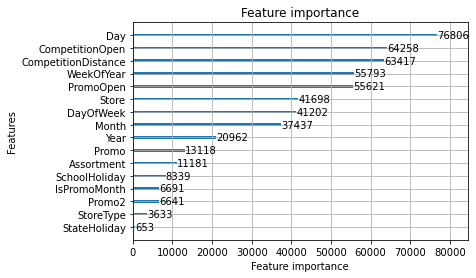

In [94]:
print('Plotting feature importances')
ax = lgb.plot_importance(gbm)
plt.show()

#### Submition

In [95]:
Xtest = test_store[selected_features]
yhat = gbm.predict(Xtest)
# I multiplied my predictions by a constant 0.985 following the recommendation at kaggle forum https://www.kaggle.com/c/rossmann-store-sales/discussion/17601 
pd.DataFrame({"Id": test_store["Id"], 'Sales': 0.985*np.expm1(yhat)}).to_csv("submissions/lgbm.csv", index=False)